# [IAPR 2020:][iapr2020] Lab 2 ‒  Object description

**Authors:** Claire Meyer, Nicolas Furrer, Philipp Schuler
**Due date:** 24.04.2020

[iapr2020]: https://github.com/LTS5/iapr-2020

## Extract relevant data
We first need to extract the `lab-02-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [1]:
import tarfile
import os

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-02-data'
# tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
# with tarfile.open(tar_path, mode='r:gz') as tar:
#     tar.extractall(path=data_base_path)

# End of cell
print("Done")

## Part 1
In the `lab-02-data/part1` folder, you will find 28x28 grey-scale pictures of handwritten "0" and "1".
These digits have been extracted from MNIST dataset (http://yann.lecun.com/exdb/mnist/).

Your goal is to extract, from each of those images, a 2-dimensional feature vector (i.e. 2 features) and to plot them all on a 2D graph.
If you have chosen good features, the vectors of the "0"'s should nicely cluster in one part of the plane and those of the "1"'s in another.

Please try first the Fourier Descriptors.
You can make several attempts: e.g. with and without invariance to rotation, translation, scaling, etc.
You can also for instance rotate the images and assess the invariance in rotation.

**Note:** for the Fourier descriptors, the u_k signal has to be constructed by following the contour point after point.
Some pre-processing (image binarization, possibly some Mathematical Morphology) might be useful.

Then feel free to try other features, the more you try, the better it will be (for you).

### 1.1 Data visualization

Done


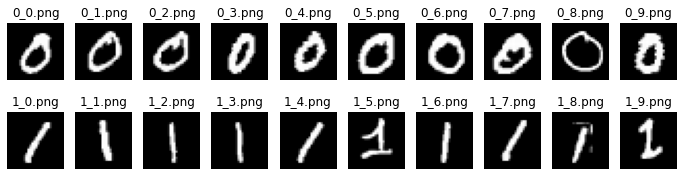

In [2]:
import skimage.io
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import cv2 as cv
import math

# Load images
data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-02-data'

# Load zeros
path_0 = os.path.join(data_base_path, data_folder, 'part1', '0')
names_0 = [nm for nm in os.listdir(path_0) if '.png' in nm]  # make sure to only load .png
names_0.sort()  # sort file names
ic = skimage.io.imread_collection([os.path.join(path_0, nm) for nm in names_0])
imgs_0 = skimage.io.concatenate_images(ic)

# Load ones
path_1 = os.path.join(data_base_path, data_folder, 'part1', '1')
names_1 = [nm for nm in os.listdir(path_1) if '.png' in nm]  # make sure to only load .png
names_1.sort()  # sort file names
ic = skimage.io.imread_collection(([os.path.join(path_1, nm) for nm in names_1]))
imgs_1 = skimage.io.concatenate_images(ic)

# Plot images
fig, axes = plt.subplots(2, len(imgs_0), figsize=(12, 3))
for ax, img, nm in zip(axes[0], imgs_0, names_0):
    ax.imshow(img, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, img, nm in zip(axes[1], imgs_1, names_1):
    ax.imshow(img, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

# End of cell
print("Done")

### 1.2 Fourier descriptors
Add your implementation and discussion

Done


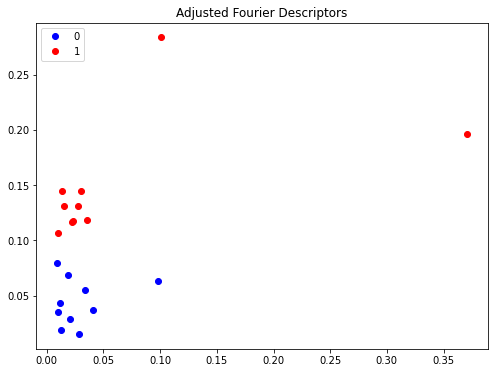

In [3]:
def fd(img, N=None, method="cropped"):
    # fd Computes the Fourier Descriptors of a shape. 
    #   [Z, Nin, m, phi, numrows, numcols] = fd(img, N=contour length, method="cropped")

    # Converting from RGB to grayscale if necessary
    if len(img.shape)==3:
        img	= cv.cvtColor(src=img, code=cv.COLOR_RGB2GRAY)
        
    # Converting to binary image
    _, img = cv.threshold(src=img, thresh=0, maxval=1, type=(cv.THRESH_BINARY | cv.THRESH_OTSU))
    [numrows, numcols]=img.shape
    
    # Extracting the contours
    contours,_ = cv.findContours(image=img, mode=cv.RETR_EXTERNAL, method=cv.CHAIN_APPROX_NONE)
    contours = np.asarray(contours).squeeze()
    
    if len(contours.shape)==1:
        i = np.argmax([len(c) for c in contours])
        contours = (contours[i][:,:]).squeeze()
    
    # Complex periodic signal out of the contours
    y = contours[:,0]
    x = contours[:,1]
    z = x + y*1j;
    Nin = z.size;
    
    # Assigning default arg
    if N is None:
        N = Nin;

    # Processing to get the fft
    Z = np.fft.fft(z);

    # Magic to get the correct signal length
    if Nin < N:
        dst = img.copy()
        cv.resize(img, dst, fx=2, fy=2, interpolation=cv.INTER_LINEAR)
        Z, Nin, _, _, _, _ = fd(dst, N, method)
    elif Nin > N:
        i = math.ceil(N/2)

        if method=="cropped":
            Z=np.concatenate((Z[:i],Z[-i:]))
        elif method=="padded":
            Z[i:-i]=0
        else:
            raise ValueError(f"Incorrect 'method' : {method}.")

    m = np.absolute(Z)
    phi = np.angle(Z)
    
    return Z, Nin, m, phi, numrows, numcols
    
    
def ifd(Z, Nin, numrows, numcols, Nout=None):
    # IFD Computes the inverse Fourier Descriptors of a complex signal. 
    #   [img] = ifd(Z, Nin, numrows, numcols, Nout = Z length)

    # Initialization
    N = Z.size

    # Assigning default arg
    if Nout is None:
        Nout = N
    
    # Magic to get the correct signal length
    if N != Nout:        
        if N < Nout:
            i = math.ceil(N/2)
            Z = np.concatenate((Z[:i],np.zeros(Nout-N),Z[i:]))
        elif N > Nout:
            i = math.ceil(Nout/2)
            Z = np.concatenate((Z[:i],Z[-i:]))

    # Processing
    z = np.fft.ifft(Z)
    z = z*Nout/Nin 
    x = z.real
    y = z.imag
    row = y.astype(np.uint8)
    col = x.astype(np.uint8)
    
    img = np.zeros((numrows, numcols), np.uint8)
    
    for xi,yi in zip(col, row):
        if (xi>=0 & yi>=0 & xi<numcols & yi<numrows):
            img[xi,yi] = 255
    
    return img

def afd(img):
    Z, _, _, _, _, _ = fd(img)
    Z = Z/Z[1]
    Z = Z[2:-1]
    m = np.absolute(Z)
    return m

modules_0 = np.zeros((10,2))
modules_1 = np.zeros((10,2))

for img_0, img_1, i in zip(imgs_0, imgs_1, range(10)):
    m = afd(img_0)
    modules_0[i,:] = m[0:2];
    m = afd(img_1)
    modules_1[i,:] = m[0:2];

n_lin = 1
n_col = 1
size = 6
fig, ax = plt.subplots(n_lin, n_col, figsize=(size*0.3981140349259/0.29538819930946153*n_col, size*n_lin))
ax.plot(modules_0[:,0], modules_0[:,1], "bo", label="0")
ax.plot(modules_1[:,0], modules_1[:,1], "ro", label="1")
ax.legend(loc="upper left")
ax.set_title(f"Adjusted Fourier Descriptors")

# End of cell
print("Done")





# prop = (ax.get_xlim()[1]-ax.get_xlim()[0])/(ax.get_ylim()[1]-ax.get_ylim()[0])

# n_lin = 1
# n_col = 1
# size = 6
# fig, ax = plt.subplots(n_lin, n_col, figsize=(n_col*size, n_lin*size))
# ax.imshow(original_img, cmap="gray")
# ax.set_title("Adjusted Fourier Descriptors")
# ax.axis("off")


### 1.3 Peak on each projection
Add your implementation and discussion

In [4]:
# Definition of function





def morphologic(list_img, morpho):
    kernel = np.zeros((3,3), np.uint8)
    cv.circle(img=kernel, center=(1,1), radius=1, color=255, thickness=-1)
    result = list_img.copy()
    for im, i, morph in zip(list_img, range(list_img.size), morpho):
        im_t = cv.inRange(im, 10,255)
        im_t = im_t/255
        copy_im = im_t.copy()
        if morph:
            result[i] = cv.morphologyEx(copy_im, cv.MORPH_OPEN, kernel, iterations=1)
        else:
            result[i] = im_t.copy()
        
    return result

# Count number of peak per axis with a value minimal of peak_value
def peak_on_axis(list_img, peak_value):
    
    peak_in_x = np.zeros(10)
    peak_in_y = np.zeros(10)
    for im, i in zip(list_img, range(list_img.size)):

        for x in range(im[0,:].size):
            if sum(im[x,:]) > peak_value:
                peak_in_x[i] = peak_in_x[i] + 1

        for y in range(im[:,0].size):
            if sum(im[:,y]) > peak_value:
                peak_in_y[i] = peak_in_y[i] + 1
                
    return peak_in_x, peak_in_y

# Plot number corresponding of each point
def plot_number(nb_peak_x,nb_peak_y):
    for x,y,i in zip(nb_peak_x, nb_peak_y, range(nb_peak_x.size)):
        plt.text(x,y, str(i), color="black", fontsize=15)
        
def transformation(list_img):
    result = np.zeros((10,28,28))
    for im, nb in zip(list_img, range(list_img.size)):
        rows,cols = im.shape
        contours,_ = cv.findContours(im, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    
        drawing = im.copy()
    
        minRect = [None]*len(contours)
    
        max_contour_area = 0
        for i, c in enumerate(contours):
            if max_contour_area < cv.contourArea(c): # take index 0 as it is the biggest contour
                max_contour_area = cv.contourArea(c)
                minRect = cv.minAreaRect(c)
                (x, y), (width, height), angle = minRect
                box = cv.boxPoints(minRect)
                box = np.intp(box) #np.intp: Integer used for indexing (same as C ssize_t; normally either int32 or int64)
        

        M1 = np.float32([[1,0,14-x],[0,1,14-y]])
        dst1 = cv.warpAffine(drawing,M1,(cols,rows))
        if(angle<-45):
            angle = angle +90
        elif(angle>45):
            angle = angle -90
        M2 = cv.getRotationMatrix2D(((cols-1)/2.0,(rows-1)/2.0),angle,1)
        result[nb] = cv.warpAffine(dst1,M2,(cols,rows))
    return result
    

Figure 0_0 peak x: 20.0 peak y: 15.0
Figure 0_1 peak x: 19.0 peak y: 17.0
Figure 0_2 peak x: 19.0 peak y: 18.0
Figure 0_3 peak x: 19.0 peak y: 14.0
Figure 0_4 peak x: 18.0 peak y: 15.0
Figure 0_5 peak x: 20.0 peak y: 18.0
Figure 0_6 peak x: 19.0 peak y: 18.0
Figure 0_7 peak x: 19.0 peak y: 20.0
Figure 0_8 peak x: 11.0 peak y: 15.0
Figure 0_9 peak x: 20.0 peak y: 15.0
Figure 1_0 peak x: 0.0 peak y: 9.0
Figure 1_1 peak x: 1.0 peak y: 6.0
Figure 1_2 peak x: 0.0 peak y: 5.0
Figure 1_3 peak x: 0.0 peak y: 4.0
Figure 1_4 peak x: 0.0 peak y: 11.0
Figure 1_5 peak x: 9.0 peak y: 10.0
Figure 1_6 peak x: 0.0 peak y: 5.0
Figure 1_7 peak x: 2.0 peak y: 10.0
Figure 1_8 peak x: 3.0 peak y: 6.0
Figure 1_9 peak x: 11.0 peak y: 7.0
Figure 0_0 peak x: 6.0 peak y: 13.0
Figure 0_1 peak x: 8.0 peak y: 15.0
Figure 0_2 peak x: 9.0 peak y: 6.0
Figure 0_3 peak x: 3.0 peak y: 10.0
Figure 0_4 peak x: 6.0 peak y: 11.0
Figure 0_5 peak x: 12.0 peak y: 17.0
Figure 0_6 peak x: 15.0 peak y: 13.0
Figure 0_7 peak x: 12.0

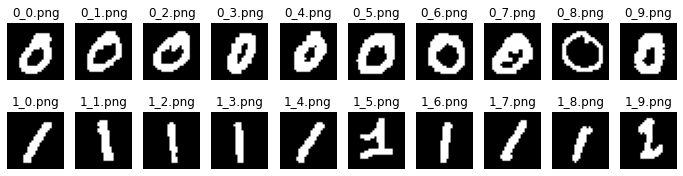

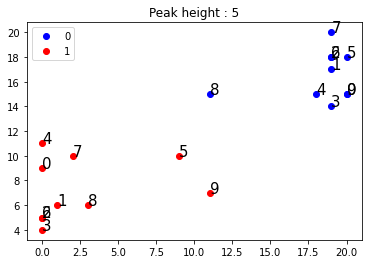

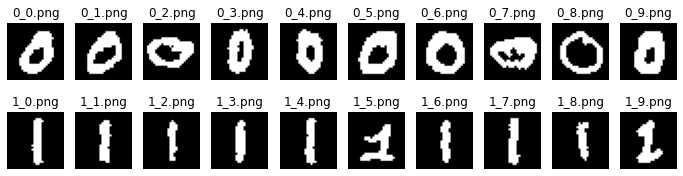

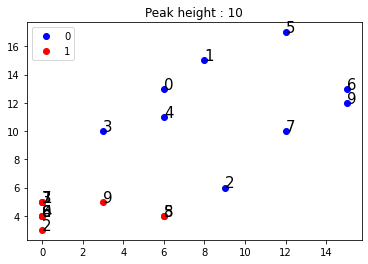

In [5]:
# # Plot images Base image
# fig, axes = plt.subplots(2, len(zeros_im), figsize=(12, 3))
# for ax, im, nm in zip(axes[0], zeros_im, zeros_names):
#     ax.imshow(im, cmap='gray')
#     ax.axis('off')
#     ax.set_title(nm)
# for ax, im, nm in zip(axes[1], ones_im, ones_names):
#     ax.imshow(im, cmap='gray')
#     ax.axis('off')
#     ax.set_title(nm)
    
# basic morphology
morph_0 = [False,False,False,False,False,False,False,False,False,False]
morph_1 = [False,False,False,False,False,False,False,False,True,False]
imgs_m_0 = morphologic(imgs_0, morph_0)
imgs_m_1 = morphologic(imgs_1, morph_1)

# Plot images After morphology
fig, axes = plt.subplots(2, len(imgs_m_0), figsize=(12, 3))
for ax, img, nm in zip(axes[0], imgs_m_0, names_0):
    ax.imshow(img, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, img, nm in zip(axes[1], imgs_m_1, names_1):
    ax.imshow(img, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
    
# Computation
peak_value = 5
nb_peak_x_0, nb_peak_y_0 = peak_on_axis(imgs_m_0,peak_value)
nb_peak_x_1, nb_peak_y_1 = peak_on_axis(imgs_m_1,peak_value)

# Plot
fig, ax = plt.subplots()
plt.title(f"Peak height : {peak_value}")
ax.plot(nb_peak_x_0, nb_peak_y_0, "bo", label='0')
ax.plot(nb_peak_x_1, nb_peak_y_1, "ro", label='1')
ax.legend(loc='upper left')
plot_number(nb_peak_x_0, nb_peak_y_0)
plot_number(nb_peak_x_1, nb_peak_y_1)

# Print
for nbx, nby, i in zip(nb_peak_x_0, nb_peak_y_0, range(10)):
    print("Figure 0_" +str(i)+ " peak x: " +str(nbx)+" peak y: " +str(nby))
    
for nbx, nby, i in zip(nb_peak_x_1, nb_peak_y_1, range(10)):
    print("Figure 1_" +str(i)+ " peak x: " +str(nbx)+" peak y: " +str(nby))
    
mt_0 = np.zeros((10,28,28))
mt_1 = np.zeros((10,28,28))

#for im, i in zip(zeros_m,range(10)):
#    zeros_mt[i] = transformation(im)

#for im, i in zip(ones_m, range(10)):
#    ones_mt[i] = transformation(im)
mt_0 = transformation(imgs_m_0)
mt_1 = transformation(imgs_m_1)
#test
fig, axes = plt.subplots(2, len(imgs_m_0), figsize=(12, 3))
for ax, img, nm in zip(axes[0], mt_0, names_0):    
    ax.imshow(img, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, img, nm in zip(axes[1], mt_1, names_1):    
    ax.imshow(img, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
    
# Computation
peak_value = 10
nb_peak_x_0, nb_peak_y_0 = peak_on_axis(mt_0,peak_value)
nb_peak_x_1, nb_peak_y_1 = peak_on_axis(mt_1,peak_value)

# Print
for nbx, nby, i in zip(nb_peak_x_0, nb_peak_y_0, range(10)):
    print("Figure 0_" +str(i)+ " peak x: " +str(nbx)+" peak y: " +str(nby))
    
for nbx, nby, i in zip(nb_peak_x_1, nb_peak_y_1, range(10)):
    print("Figure 1_" +str(i)+ " peak x: " +str(nbx)+" peak y: " +str(nby))

# Plot
fig, ax = plt.subplots()
plt.title(f"Peak height : {peak_value}")
ax.plot(nb_peak_x_0, nb_peak_y_0, "bo", label='0')
ax.plot(nb_peak_x_1, nb_peak_y_1, "ro", label='1')
ax.legend(loc='upper left')
plot_number(nb_peak_x_0, nb_peak_y_0)
plot_number(nb_peak_x_1, nb_peak_y_1)
    

# End of cell
print("Done")

#### Minimum area oriented rectangle and closed loops
Two additional methods to extract features from the images are the ratio of a oriented rectangle around the white opints of the images and the number of closed loops. 
The function below extract these features and returns different informations:
 - the two features we want
 - the images of the rectangles for debug purposes
 - the number of contours (can also be used as faeture, but less precise)


The rectangle ratio calculation is done this way:
 - Take the original and find the contours.
 - Then only for the biggest contour, find the minimum area rectangle around the contour
 - Calculate the width/height ratio of this contour. This is the first feature we'll use
 
The closed loops are found with these steps:
 - Threshold the image to obtain a simple binary image
 - With the `connectedComponentsWithStats()` function, extract the number of closed shapes.
 - As the background, and the drawing are a distinct shape, we subtract these from the returned number, thus getting the number of closed loops
 
We then return the needed informations
 

In [6]:
# returns the ratio of the rotated rectangle. This shows if it is elongated or not, thus if it is close to a 1 or a 0.
def getRatio(img):
       
    contours,_ = cv.findContours(img, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    
    drawing = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    cv.drawContours(drawing, contours, 0, [255,255,255])
    
    minRect = [None]*len(contours)
    
    max_contour_area = 0
    for i, c in enumerate(contours):
        cv.drawContours(drawing, contours, i, [255,255,255])
        if max_contour_area < cv.contourArea(c): # take index 0 as it is the biggest contour
            max_contour_area = cv.contourArea(c)
            minRect = cv.minAreaRect(c)
            (x, y), (width, height), angle = minRect
            box = cv.boxPoints(minRect)
            box = np.intp(box) #np.intp: Integer used for indexing (same as C ssize_t; normally either int32 or int64)

    total_contours = i+1;
    cv.drawContours(drawing, [box], 0, [255,0,0])
    if width >= height:
        ratio = width/height
    else:
        ratio = height/width
    
    return ratio, drawing, total_contours


# returns the number of closed loops in the image
def getClosedLoops(img):
    
    # number of centroids, this gives the number of closed loops + 2 (background + first color)
    _, thresh = cv.threshold(img, 1, 255, cv.THRESH_BINARY)
    ret, labels, stats, centroids = cv.connectedComponentsWithStats(cv.bitwise_not(thresh),4)
    
    closed_loops = int(centroids.size/2)-2
    
    return closed_loops


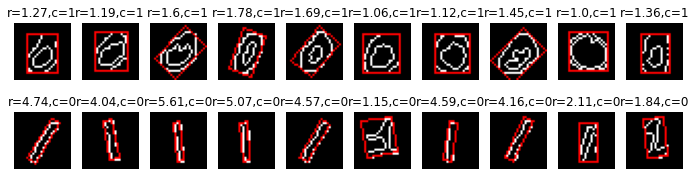

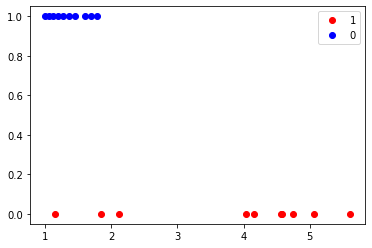

In [7]:
## rotated rectangle + nb of closed loops

fig, axes = plt.subplots(2, len(imgs_0), figsize=(12, 3))

x_0, y_0 = [], [];
x_1, y_1 = [], [];

for ax, img, nm in zip(axes[0], imgs_0, names_0):
    
    ratio, drawing, tc =  getRatio(img)
    cl = getClosedLoops(img)
    
    x_0.append(ratio)
    y_0.append(cl)
    
    ax.imshow(drawing, cmap='gray')
    ax.axis('off')
    ax.set_title("r="+str(round(ratio,2))+",c="+str(cl))
    
for ax, img, nm in zip(axes[1], imgs_1, names_1):
    
    ratio, drawing, tc =  getRatio(img)
    cl = getClosedLoops(img)
    
    x_1.append(ratio)
    y_1.append(cl)
    
    ax.imshow(drawing, cmap='gray')
    ax.axis('off')
    ax.set_title("r="+str(round(ratio,2))+",c="+str(cl))
    
    
fig, ax = plt.subplots()
ax.plot(x_1,y_1,'ro')
ax.plot(x_0,y_0,'bo')
ax.legend(['1','0'])

# End of cell
print("Done")

## Part 2
The `lab-02-data/part2` folder contains grey-scale pictures of handwritten "2" and "3".
Extract the same feature (typically 2 Fourier descriptors) as in part 1 also on these images and plot them on the same graph as the features of the "0" and "1".
Is it possible to discriminate all these 4 digits with a 2-dimensional feature vector?

### 2.1 Data visualization

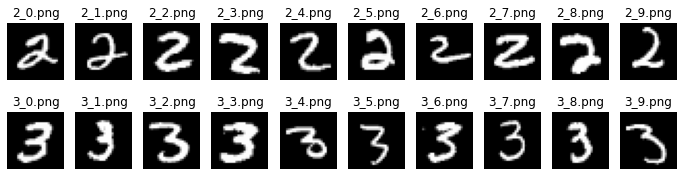

In [8]:
# Load twos
path_2 = os.path.join(data_base_path, data_folder, 'part2', '2')
names_2 = [nm for nm in os.listdir(path_2) if '.png' in nm]  # make sure to only load .png
names_2.sort()  # sort file names
ic = skimage.io.imread_collection([os.path.join(path_2, nm) for nm in names_2])
imgs_2 = skimage.io.concatenate_images(ic)

# Load threes
path_3 = os.path.join(data_base_path, data_folder, 'part2', '3')
names_3 = [nm for nm in os.listdir(path_3) if '.png' in nm]  # make sure to only load .png
names_3.sort()  # sort file names
ic = skimage.io.imread_collection(([os.path.join(path_3, nm) for nm in names_3]))
imgs_3 = skimage.io.concatenate_images(ic)

# Plot images
fig, axes = plt.subplots(2, len(imgs_2), figsize=(12, 3))
for ax, im, nm in zip(axes[0], imgs_2, names_2):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], imgs_3, names_3):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

# End of cell
print("Done")

### 2.2 Additional method(s) and conclusion
Add your implementations and discussions here

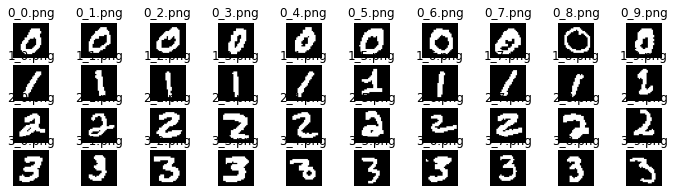

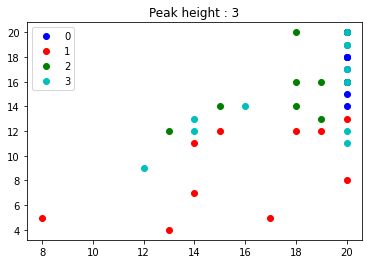

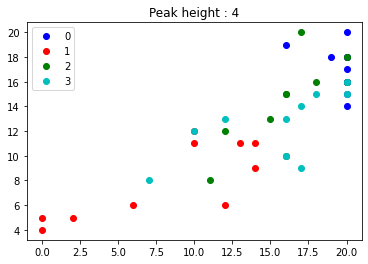

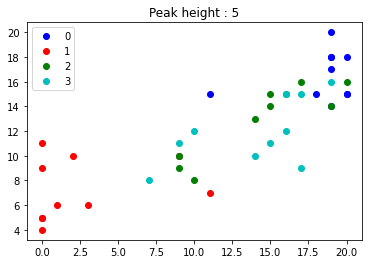

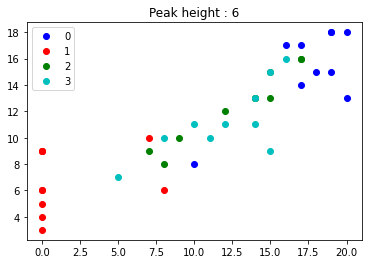

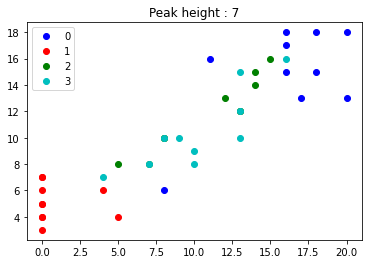

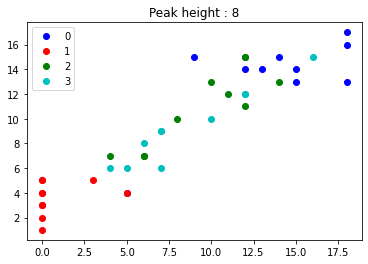

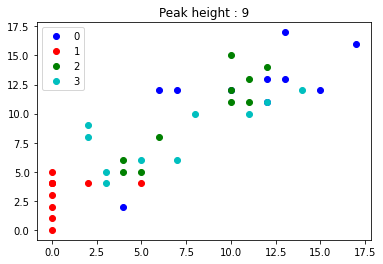

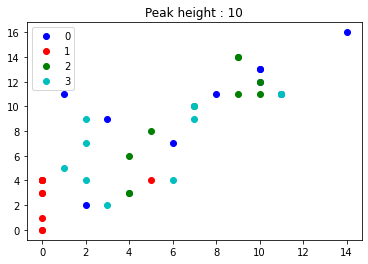

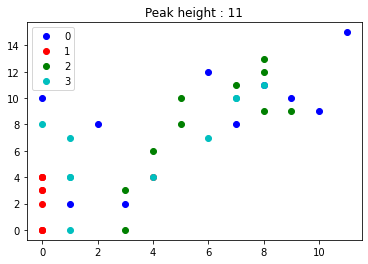

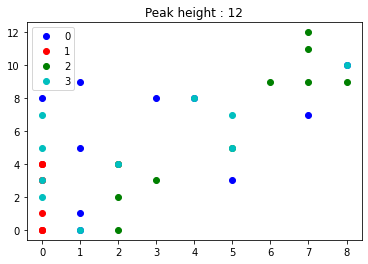

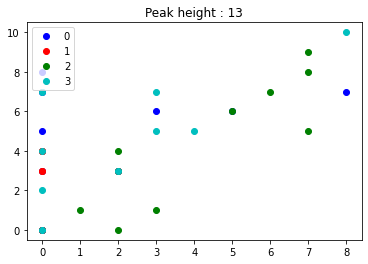

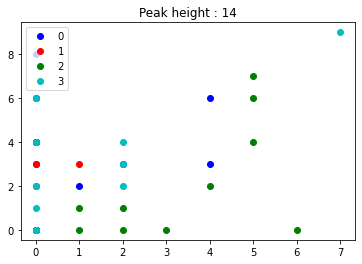

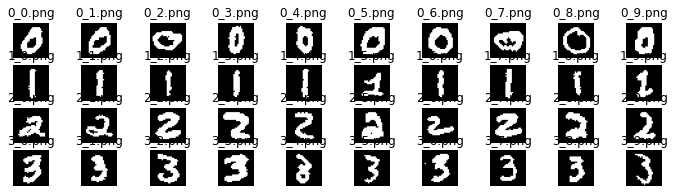

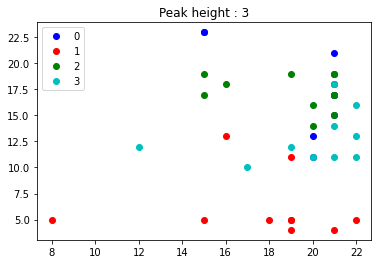

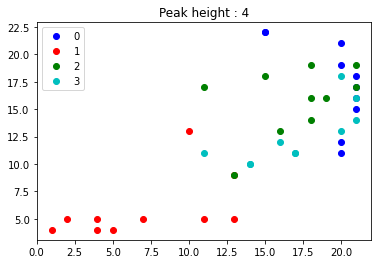

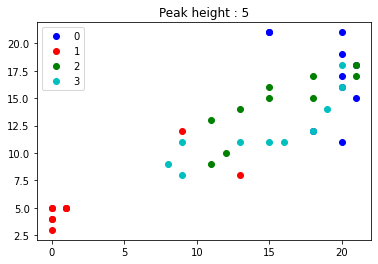

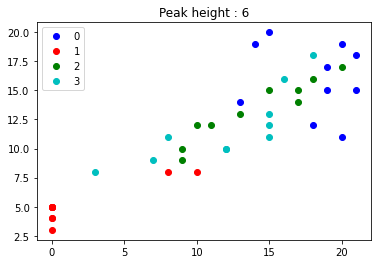

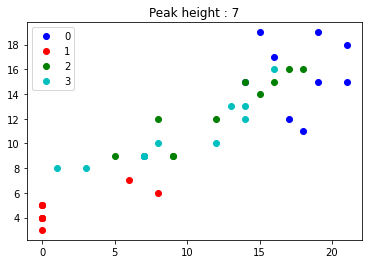

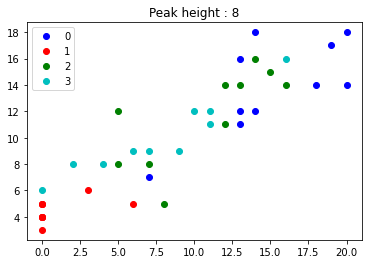

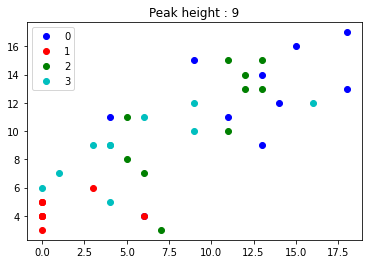

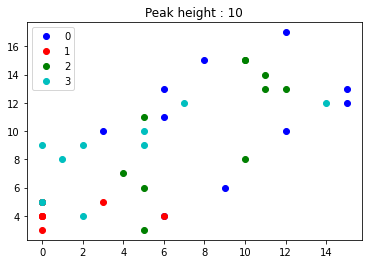

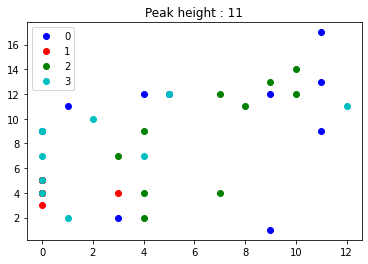

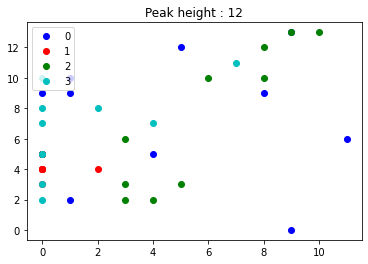

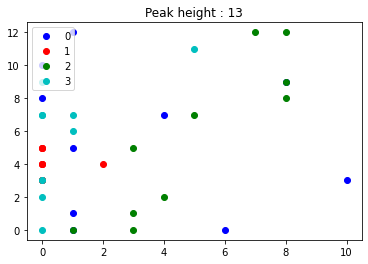

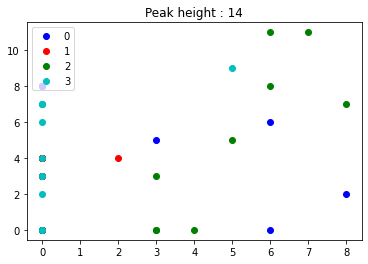

In [9]:
#Preparation
morph_0 = [False,False,False,False,False,False,False,False,False,False]
morph_1 = [False,False,False,False,False,False,False,False,True,False]
morph_2 = [False,False,False,False,False,False,False,False,False,False]
morph_3 = [False,False,False,False,False,False,False,False,False,False]

imgs_m_0 = morphologic(imgs_0, morph_0)
imgs_m_1 = morphologic(imgs_1, morph_1)
imgs_m_2 = morphologic(imgs_2, morph_2)
imgs_m_3 = morphologic(imgs_3, morph_3)

mt_0 = transformation(imgs_m_0)
mt_1 = transformation(imgs_m_1)
mt_2 = transformation(imgs_m_2)
mt_3 = transformation(imgs_m_3)

fig, axes = plt.subplots(4, len(imgs_m_0), figsize=(12, 3))
for ax, img, nm in zip(axes[0], imgs_m_0, names_0):    
    ax.imshow(img, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, img, nm in zip(axes[1], imgs_m_1, names_1):    
    ax.imshow(img, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, img, nm in zip(axes[2], imgs_m_2, names_2):    
    ax.imshow(img, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, img, nm in zip(axes[3], imgs_m_3, names_3):    
    ax.imshow(img, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

 
    
    
#Peak on axis test with number 0 to 3
for peak_value in range(3, 15):
    
    # Computation
    nb_peak_x_0, nb_peak_y_0 = peak_on_axis(imgs_m_0, peak_value)
    nb_peak_x_1, nb_peak_y_1 = peak_on_axis(imgs_m_1, peak_value)
    nb_peak_x_2, nb_peak_y_2 = peak_on_axis(imgs_m_2, peak_value)
    nb_peak_x_3, nb_peak_y_3 = peak_on_axis(imgs_m_3, peak_value)

    # Plot
    fig, ax = plt.subplots()
    plt.title(f"Peak height : {peak_value}")
    ax.plot(nb_peak_x_0, nb_peak_y_0, "bo", label='0')
    ax.plot(nb_peak_x_1, nb_peak_y_1, "ro", label='1')
    ax.plot(nb_peak_x_2, nb_peak_y_2, "go", label='2')
    ax.plot(nb_peak_x_3, nb_peak_y_3, "co", label='3')
    ax.legend(loc='upper left')
    plt.show()
    
    
fig, axes = plt.subplots(4, len(imgs_m_0), figsize=(12, 3))
for ax, img, nm in zip(axes[0], mt_0, names_0):    
    ax.imshow(img, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, img, nm in zip(axes[1], mt_1, names_1):    
    ax.imshow(img, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, img, nm in zip(axes[2], mt_2, names_2):    
    ax.imshow(img, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, img, nm in zip(axes[3], mt_3, names_3):    
    ax.imshow(img, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)   
for peak_value in range(3, 15):
    
    # Computation
    nb_peak_x_0, nb_peak_y_0 = peak_on_axis(mt_0, peak_value)
    nb_peak_x_1, nb_peak_y_1 = peak_on_axis(mt_1, peak_value)
    nb_peak_x_2, nb_peak_y_2 = peak_on_axis(mt_2, peak_value)
    nb_peak_x_3, nb_peak_y_3 = peak_on_axis(mt_3, peak_value)

    # Plot
    fig, ax = plt.subplots()
    plt.title(f"Peak height : {peak_value}")
    ax.plot(nb_peak_x_0, nb_peak_y_0, "bo", label='0')
    ax.plot(nb_peak_x_1, nb_peak_y_1, "ro", label='1')
    ax.plot(nb_peak_x_2, nb_peak_y_2, "go", label='2')
    ax.plot(nb_peak_x_3, nb_peak_y_3, "co", label='3')
    ax.legend(loc='upper left')
    plt.show()

# End of cell
print("Done")

#### 2.2.3 Oriented Rectangle + # of contours

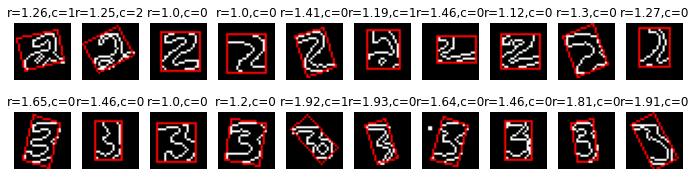

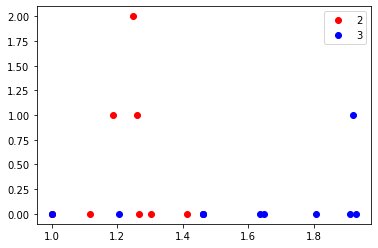

In [10]:
fig, axes = plt.subplots(2, len(imgs_0), figsize=(12, 3))

x_2, y_2 = [], [];
x_3, y_3 = [], [];

for ax, img, nm in zip(axes[0], imgs_2, names_2):
    
    ratio, drawing, tc =  getRatio(img)
    cl = getClosedLoops(img)
    
    x_2.append(ratio)
    y_2.append(cl)
    
    ax.imshow(drawing, cmap='gray')
    ax.axis('off')
    ax.set_title("r="+str(round(ratio,2))+",c="+str(cl))
    
for ax, img, nm in zip(axes[1], imgs_3, names_3):
    
    ratio, drawing, tc =  getRatio(img)
    cl = getClosedLoops(img)
    
    x_3.append(ratio)
    y_3.append(cl)
    
    ax.imshow(drawing, cmap='gray')
    ax.axis('off')
    ax.set_title("r="+str(round(ratio,2))+",c="+str(cl))
    
fig, ax = plt.subplots()
ax.plot(x_2,y_2,'ro')
ax.plot(x_3,y_3,'bo')
ax.legend(['2','3'])

# End of cell
print("Done")